In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T

# from dask.distributed import Client
# from dask_gateway import GatewayCluster

import pystac_client
import planetary_computer as pc


import sys
import os

current_folder = os.getcwd()
sys.path.insert(0, '/home/jovyan/sdm-geolifeCLEF/raster')
sys.path.insert(0, '/home/jovyan/sdm-geolifeCLEF/models')

from inception_env import InceptionEnv

from torch.optim.lr_scheduler import MultiStepLR

import sys
for path in sys.path:
    print(path)
print(current_folder)    

/home/jovyan/sdm-geolifeCLEF/models
/home/jovyan/sdm-geolifeCLEF/raster
/home/jovyan/sdm-geolifeCLEF/training
/srv/conda/envs/notebook/lib/python39.zip
/srv/conda/envs/notebook/lib/python3.9
/srv/conda/envs/notebook/lib/python3.9/lib-dynload

/srv/conda/envs/notebook/lib/python3.9/site-packages
/home/jovyan/sdm-geolifeCLEF/training


In [2]:
torch.__version__

'1.12.1.post200'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
from zarr_dataset import Zarr_Dataset

# Read Zarr Dataset

## KDE

In [6]:
LOCAL_FILES = True

BUCKET_NAME = 'datasets-sdm'
folder_f = 'geoLifeCLEF/features'
folder_l = 'geoLifeCLEF/labels'
# s3://datasets-sdm/geoLifeCLEF/features/
filename_train_f = 'train_ca_6000m_64px_features.zarr'
filename_train_l = 'geolifeclef_ca_0.05deg_kde_0.1deg_epanechnikov.zarr'
filename_val_f   = 'val_ca.zarr'
filename_val_l   = 'ca_val_obs_val.zarr'
s3_train_path_f  = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_f, filename_train_f)
s3_train_path_l  = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_l, filename_train_l)
s3_val_path_f    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_f, filename_val_f)
s3_val_path_l    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_l, filename_val_l)

local_val_path = '../data/val_ca.zarr'
local_train_path_f = '../data/features/train_ca_6000m_64px_features.zarr'
# local_train_path_l = '../data/labels/train_ca_0.05deg_kde_0.1deg_ep_labels.zarr'
local_train_path_l = '../data/labels/train_ca_0.05deg_kde_0.5deg_ep_labels.zarr'
local_val_path_f = None
local_val_path_l = None

if LOCAL_FILES:
    train_path_f, train_path_l = local_train_path_f, local_train_path_l
    val_path_f, val_path_l = local_val_path_f, local_val_path_l
else:
    train_path_f, train_path_l = s3_train_path_f, s3_train_path_l
    val_path_f, val_path_l = s3_val_path_f, s3_val_path_l
    


# s3_example_path = 's3://{}/{}/example.zarr'.format(BUCKET_NAME, folder_f)

print("Train paths: ", train_path_f, train_path_l)
print("Val paths  : ", val_path_f, val_path_l)

Train paths:  ../data/features/train_ca_6000m_64px_features.zarr ../data/labels/train_ca_0.05deg_kde_0.5deg_ep_labels.zarr
Val paths  :  None None


## Setup Train dataset and dataloader

In [7]:
# train_dataset = Zarr_Dataset(s3_train_path)
train_dataset = Zarr_Dataset(filepath_f=train_path_f, filepath_l=train_path_l)

In [8]:
train_dataset.info()

Features:
  Type               : zarr.core.Array
Data type          : object
Shape              : (17173,)
Chunk shape        : (1,)
Order              : C
Read-only          : True
Filter [0]         : Pickle(protocol=5)
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Synchronizer type  : zarr.sync.ThreadSynchronizer
Store type         : zarr.storage.DirectoryStore
No. bytes          : 137384 (134.2K)
No. bytes stored   : 14156117517 (13.2G)
Storage ratio      : 0.0
Chunks initialized : 17173/17173

Labels:
  Type               : zarr.core.Array
Data type          : object
Shape              : (17173,)
Chunk shape        : (1,)
Order              : C
Read-only          : True
Filter [0]         : Pickle(protocol=5)
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Synchronizer type  : zarr.sync.ThreadSynchronizer
Store type         : zarr.storage.DirectoryStore
No. bytes          : 137384 (134.2K)
No. bytes stored   : 27840

In [9]:
len(train_dataset)

17173

### Quick test

In [10]:
p,t = train_dataset[13]

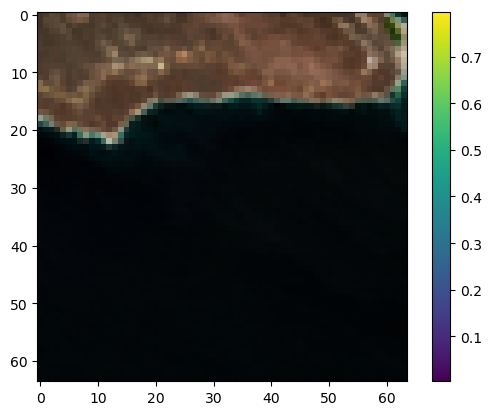

In [11]:
img = p[0:3,:,:]
plt.imshow(img.permute(1, 2, 0))
plt.colorbar()
plt.show()

(tensor(0.3929), tensor(0.))

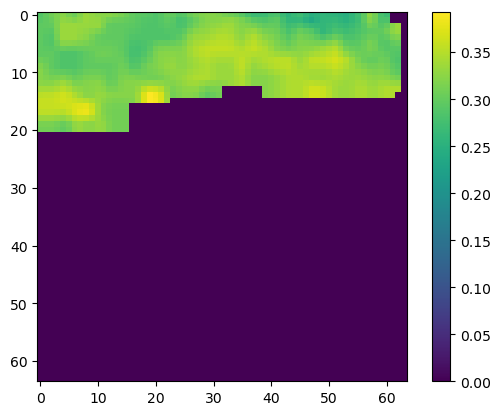

In [12]:
idx = -5
ped = p[idx].unsqueeze(dim=0)#-> Remove first dim (channel) 
plt.imshow(ped.permute(1, 2, 0))#, vmax=1.0)
plt.colorbar()
p[idx].max(), p[idx].min()

In [13]:
demo = train_dataset[0]
N_LABELS = demo[1].shape[0]
N_INPUTS = demo[0].shape[0]
N_LABELS, N_INPUTS

(5079, 31)

### Convenience functions

In [14]:
def AccuracyTopK(predictions, labels, k:int=30, one_hot:bool=True):

    """Returns a '1' for every time a value in the top-k of predicitons is present in the 
       top-k of labels. This is then normalized by the number of predictions
       results can have a maximum value of 1.0
       params:
           - predictions: tensor of [batch_size, num_classes]
           - labels: tensor of [batch_size, num_classes]
    """
    
    res = 0.
    batch_size = labels.shape[0]
    
    
    
    for i, pred in enumerate(predictions):
        top_k_preds = np.argpartition(pred,-k)[-k:]
        
        if not one_hot:
            top_k_labels = np.argpartition(labels[i],-k)[-k:]

            if top_k_preds in top_k_labels:
                res += 1.
        else:
            # There's only one-winner for 1 hot encoded
            # top_k_labels = np.argpartition(labels[i],-1)[-1:]
            top_k_labels = np.argmax(labels[i])
            
            if top_k_labels in top_k_preds:
                res += 1.
                # print("[{}] top_k label = {} | top_k preds = {}".format(i,top_k_labels,top_k_preds))
                # print (res, labels.shape[0])
                
    print("Accuracy [k={:}]:\t\t{:.3}%".format(k,(res/labels.shape[0])*100.))
    # return res / labels.shape[0]

def AccuracyTopKSpecies(predictions, labels, k:int=30, one_hot:bool=True):

    """Returns a '1' for every time a value in the top-k of predicitons is present in the 
       top-k of labels. This is then normalized by the number of predictions
       results can have a maximum value of 1.0
       params:
           - predictions: tensor of [batch_size, num_classes]
           - labels: tensor of [batch_size, num_classes]
    """
    
    #a counter per species
    # counts = np.zeros(shape=predictions.shape[1])
    total_count = 0.
    
    unique_species = []
    occurence_species = []  #a list of lists that holds all the observation indexes (rows) for each species in unique_species
    
    
    #Find all unique species index
    for species_id, obs in enumerate(labels.T):
        if obs.sum() > 0:
            unique_species.append(species_id)
            idxs = np.nonzero(obs)
            occurence_species.append(idxs[0])

        
    num_species = len(unique_species)
    
    for i in range(num_species):
        # print("Observation id[{:}] for species[{:}]:{:}".format(i, unique_species[i], occurence_species[i]))
        
        species_count = 0.
        #iterate over every occurence of that species
        for j in occurence_species[i]:#j is the observation id 
            #calculate the top-K score for that observation
            #Grab the predictions for that observation
            pred = predictions[j]
            top_k_preds = np.argpartition(pred,-k)[-k:]
            label = np.argmax(labels[j])
            
            
            if label in top_k_preds:
                species_count += 1.
        #Now normalize it by occurence of that species
        species_count /= len(occurence_species[i])
        total_count += species_count
        
    #All done, now normalize by unique species count
    total_count /= num_species
    
    print("Accuracy [k={:},s={:}]:\t{:.3}%".format(k,num_species,total_count*100.))
    # return total_count
    


In [15]:
def predict(model, loader, device, batch_size, validation_size=-1):
    """
        Give the prediction of the model on a test set
        :param model: the model
        :param test_loader: the test set loader
        :param validation_size: number of occurrences for the validation
    """
    
    validation_size = validation_size / batch_size if validation_size > -1 else -1
    
    with torch.no_grad():
        
        model.eval()

        y_preds = None
        y_labels = None
        count = 0
        
        for inputs, labels in tqdm(loader, leave=False):
            
            # y_labels.extend(labels)
            if y_labels is not None:
                y_labels = np.vstack((y_labels, labels.data.numpy()))
            else:
                y_labels = labels.data.numpy()
                
            
            # inputs, labels = inputs.type(torch.cuda.FloatTensor).to(device), labels.to(device)
            inputs, labels = inputs.to(device), labels.to(device)
            
            output_batch = model(inputs)
            
            output_batch = output_batch.data.cpu().numpy()
            
            # if(count % 100 == 0):
            #     print(outputs.shape, outputs.dtype)
                
            if y_preds is not None:
                y_preds = np.vstack((y_preds, output_batch))
            else:
                y_preds = output_batch
            
            # print(y_preds.shape, y_labels.shape)

            # y_preds.extend(outputs.cpu().tolist())
            # y_preds.extend(outputs.data.tolist())
            # y_labels.extend(labels)

            count += 1
            if validation_size > -1 and count >= validation_size:
                break

        # print(y_preds[0].shape,y_labels[0].shape)
        # predictions, labels = np.asarray(y_preds, dtype=object), np.asarray(y_labels, dtype=object)
        

    return y_preds, y_labels

In [16]:
from tqdm.notebook import tqdm
def validate (num_epochs, model, device, loader, batch_size=32, validation_size=-1, top_k=[30]):
    
    # model = model.to(device)
    
    for epoch in tqdm(range(num_epochs)):

        predictions, labels = predict(model, loader, device, batch_size, validation_size)
        
        print(predictions.shape, labels.shape)

        # evatuate
        # res_topK, res_topKSpecies = [], []
        for k in top_k:
            AccuracyTopK(predictions, labels, k)
            AccuracyTopKSpecies(predictions, labels, k)
            # res.append(acc*100.)
            # print("AccuracyTopK[top_k={}] = {:.4}%".format(k,res[-1]))

In [17]:
def save_model(PATH, model, optimizer):
    
    if scheduler:
        ssd = scheduler.state_dict()
    else:
        ssd = None
        
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': ssd,
            'loss': train_loss,
            'NUM_EPOCHS' : NUM_EPOCHS,
            'BATCH_SIZE' : BATCH_SIZE,
            'GAMMA' : GAMMA,
            'LR' : LR,
            'MODEL': MODEL,
            'OPTIM' : OPTIM
            }, PATH)
    
    
def load_model(PATH):
    checkpoint = torch.load(PATH)
    
    NUM_EPOCHS = checkpoint['NUM_EPOCHS'] if checkpoint['NUM_EPOCHS'] else None 
    BATCH_SIZE = checkpoint['BATCH_SIZE'] if checkpoint['BATCH_SIZE'] else None
    GAMMA      = checkpoint['GAMMA'] if checkpoint['GAMMA'] else None
    LR         = checkpoint['LR'] if checkpoint['LR'] else 1e-3
    MODEL      = checkpoint['MODEL'] if checkpoint['MODEL'] else 'inet'
    OPTIM      = checkpoint['OPTIM'] if checkpoint['OPTIM'] else 'AdamW'
    
    print("Epochs:{} | Batch_size: {} | Gamma: {} | LR: {} | Model: {} | Optim: {}"\
          .format(NUM_EPOCHS, BATCH_SIZE, GAMMA, LR, MODEL, OPTIM))
    
    if MODEL == 'inet':
        model = InceptionEnv(dropout=DROPOUT, n_labels=N_LABELS, n_input=N_INPUTS)
        print("Loading InceptioNet")
        
    model.load_state_dict(checkpoint['model_state_dict'])
        
    if OPTIM == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
        print("Optimizer: SGD")
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=(0.9, 0.95), weight_decay=0.1)
        print ("Optimizer:AdamW")
        
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if checkpoint['scheduler_state_dict']:
        scheduler = MultiStepLR(optimizer, milestones=iterations, gamma=GAMMA)
        print("Scheduler: MultiStepLR")
    else :
        scheduler = None
        

    train_loss = checkpoint['loss']
    
    print("Train loss sequence: \n", train_loss)
    
    return model, optimizer, scheduler, train_loss


# Train/predict setup

## Train the model

In [18]:
# from train import fit
# from predict import predict
from evaluation import evaluate
from metrics import ValidationAccuracyMultipleBySpecies
from metrics import ValidationAccuracyMultiple


BATCH_SIZE = 128
NUM_WORKERS = 8


iterations = [20,40,60,80,100]#,140,160,180,200]
#test
# iterations = [1]
NUM_EPOCHS = iterations[-1]

LOG_MODULO = 50 #
VAL_MODULO = 5

# LR = 5e-4 * batch_size / 256
GAMMA = 0.1
DROPOUT = 0.7

MODEL = 'inet'
OPTIM = 'SGD' #'AdamW'

# evaluation
# METRICS = (ValidationAccuracyMultipleBySpecies([30]), ValidationAccuracyMultiple([30]))
# METRICS = (ValidationAccuracyMultiple([30,50]))

In [19]:
import gc
# inet.to('cpu')
# del inet
# del train_set#, val_set
# del train_loader#, val_loader
# del val_dataset, val_loader
gc.collect()

11519

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [21]:
most_recent_loss = None
train_loss = []
completed_epochs = 0

In [ ]:
inet = InceptionEnv(dropout=DROPOUT, n_labels=N_LABELS, n_input=N_INPUTS)
inet

InceptionNet in mlmc mode

In [23]:
criterion = torch.nn.CrossEntropyLoss()


if OPTIM == 'SGD':
    LR = 0.1  #always use this with a scheduler which will decay the LR every some epoch
    optimizer = torch.optim.SGD(inet.parameters(), lr=LR, momentum=0.9)
    
else:
    LR = 0.1
    optimizer = torch.optim.AdamW(inet.parameters(), lr=LR, betas=(0.9, 0.95), weight_decay=GAMMA)
    
    
scheduler = MultiStepLR(optimizer, milestones=iterations, gamma=GAMMA)



In [25]:
optimizer, scheduler

(SGD (
 Parameter Group 0
     dampening: 0
     foreach: None
     initial_lr: 0.1
     lr: 0.1
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ),
 <torch.optim.lr_scheduler.MultiStepLR at 0x7f71910a06a0>)

In [34]:
from tqdm.notebook import tqdm
import time

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler=None, completed_epochs=0, val_modulo=1):
    
    print('beginning to train model')
    model = model.to(device)
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        start_time = time.perf_counter()
        for inputs, labels in tqdm(train_loader, leave=False):
            # print("Train loop dtypes: ", inputs.dtype, labels.dtype)
            inputs, labels = inputs.type(torch.cuda.FloatTensor).to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
         
        # completed_epochs += 1
        
        if scheduler:
            scheduler.step()
            
        end_time = time.perf_counter()
        duration = end_time - start_time
        #train_acc = compute_accuracy(model, train_loader)
        # val_acc = compute_accuracy(model, val_loader)
        
        train_loss.append(running_loss / len(train_loader))
        
        most_recent_loss = train_loss[-1]
        
        if val_loader and epoch % val_modulo == 0:
            validate(1, model, val_loader, device, validation_size=1000)
        
        completed_epochs = epoch+1
        print("Epoch: {0:02d} | Training Loss: {1:.5f} | Time: {2:.3f}".format(completed_epochs, most_recent_loss, duration))
        
    return completed_epochs
        

In [27]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

/srv/conda/envs/notebook/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [33]:
len(train_loader)

135

In [ ]:
completed_epochs = train(model=inet, train_loader=train_loader, val_loader=None, num_epochs=NUM_EPOCHS, criterion=criterion, optimizer=optimizer, scheduler=scheduler, completed_epochs=completed_epochs)
# train(inet, train_loader, None, NUM_EPOCHS, criterion, optimizer)

beginning to train model


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 01 | Training Loss: 1987.42849 | Time: 188.446


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 02 | Training Loss: 1990.70944 | Time: 191.258


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 03 | Training Loss: 1985.59145 | Time: 191.644


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 04 | Training Loss: 1976.72692 | Time: 191.791


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 05 | Training Loss: 1973.93889 | Time: 191.554


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 06 | Training Loss: 1973.61891 | Time: 191.610


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 07 | Training Loss: 1974.56974 | Time: 191.501


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 08 | Training Loss: 1972.72733 | Time: 191.688


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 09 | Training Loss: 1974.20833 | Time: 191.564


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 10 | Training Loss: 1970.93944 | Time: 191.660


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 11 | Training Loss: 1973.02216 | Time: 191.514


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 12 | Training Loss: 1966.52236 | Time: 191.534


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 13 | Training Loss: 1965.89000 | Time: 191.662


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 14 | Training Loss: 1974.56522 | Time: 191.557


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 15 | Training Loss: 1969.81940 | Time: 191.654


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 16 | Training Loss: 1966.57088 | Time: 191.597


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 17 | Training Loss: 1965.63154 | Time: 191.716


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 18 | Training Loss: 1968.84221 | Time: 191.889


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 19 | Training Loss: 1962.77374 | Time: 191.549


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 20 | Training Loss: 1962.87884 | Time: 191.571


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 21 | Training Loss: 1961.63766 | Time: 191.820


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 22 | Training Loss: 1961.02082 | Time: 191.838


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 23 | Training Loss: 1962.22928 | Time: 191.808


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 24 | Training Loss: 1962.37993 | Time: 191.782


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 25 | Training Loss: 1965.78382 | Time: 191.783


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 26 | Training Loss: 1963.06520 | Time: 192.097


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 27 | Training Loss: 1962.41984 | Time: 191.979


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 28 | Training Loss: 1960.21298 | Time: 191.911


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 29 | Training Loss: 1955.67180 | Time: 191.863


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 30 | Training Loss: 1960.30404 | Time: 192.081


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 31 | Training Loss: 1961.45290 | Time: 192.115


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 32 | Training Loss: 1954.83818 | Time: 191.881


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 33 | Training Loss: 1957.69285 | Time: 192.076


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 34 | Training Loss: 1962.51444 | Time: 191.928


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 35 | Training Loss: 1960.14321 | Time: 192.107


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 36 | Training Loss: 1961.67074 | Time: 192.221


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 37 | Training Loss: 1955.99315 | Time: 192.090


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 38 | Training Loss: 1960.93999 | Time: 192.191


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 39 | Training Loss: 1955.02889 | Time: 192.138


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 40 | Training Loss: 1954.71239 | Time: 192.024


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 41 | Training Loss: 1955.88533 | Time: 191.944


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 42 | Training Loss: 1956.86706 | Time: 192.103


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 43 | Training Loss: 1957.78848 | Time: 191.911


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 44 | Training Loss: 1958.44412 | Time: 191.873


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 46 | Training Loss: 1957.34573 | Time: 191.962


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 47 | Training Loss: 1961.85468 | Time: 191.913


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 48 | Training Loss: 1959.23417 | Time: 191.730


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 49 | Training Loss: 1959.83143 | Time: 192.035


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 50 | Training Loss: 1964.09270 | Time: 192.123


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 51 | Training Loss: 1958.66390 | Time: 192.028


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 52 | Training Loss: 1956.33127 | Time: 191.963


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 53 | Training Loss: 1958.12017 | Time: 192.221


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 54 | Training Loss: 1959.33527 | Time: 192.024


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 55 | Training Loss: 1958.68427 | Time: 192.088


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 56 | Training Loss: 1962.39279 | Time: 191.604


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 57 | Training Loss: 1954.51206 | Time: 191.677


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 58 | Training Loss: 1959.77904 | Time: 191.535


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 59 | Training Loss: 1955.04376 | Time: 191.488


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 60 | Training Loss: 1960.68987 | Time: 191.831


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 61 | Training Loss: 1960.36263 | Time: 191.880


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 62 | Training Loss: 1957.29221 | Time: 191.877


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 63 | Training Loss: 1957.57389 | Time: 191.857


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 64 | Training Loss: 1956.69624 | Time: 192.211


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 65 | Training Loss: 1951.32183 | Time: 192.025


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 66 | Training Loss: 1954.80611 | Time: 192.056


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 67 | Training Loss: 1956.71733 | Time: 191.758


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 68 | Training Loss: 1955.70443 | Time: 192.012


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 69 | Training Loss: 1957.28368 | Time: 191.781


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 70 | Training Loss: 1957.56120 | Time: 191.588


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 71 | Training Loss: 1957.65189 | Time: 191.883


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 72 | Training Loss: 1959.96300 | Time: 191.998


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 73 | Training Loss: 1957.91106 | Time: 192.028


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 74 | Training Loss: 1955.44761 | Time: 191.863


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 75 | Training Loss: 1952.94908 | Time: 191.982


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 76 | Training Loss: 1956.32424 | Time: 192.014


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 77 | Training Loss: 1960.37122 | Time: 191.967


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 78 | Training Loss: 1956.08783 | Time: 191.727


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 79 | Training Loss: 1955.66568 | Time: 191.964


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 80 | Training Loss: 1957.18677 | Time: 191.806


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 81 | Training Loss: 1963.12435 | Time: 191.862


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 82 | Training Loss: 1957.32386 | Time: 191.895


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 83 | Training Loss: 1958.71438 | Time: 191.998


  0%|          | 0/135 [00:00<?, ?it/s]

## Save model states

In [ ]:
import datetime
date = datetime.datetime.strptime(str(datetime.datetime.now()), "%Y-%m-%d  %H:%M:%S.%f")

filename_model = 'inet_{}{}{}-{}{}-b{}-e{}-{}.tar'.format(date.year, date.month, date.day, date.hour, date.minute, BATCH_SIZE, completed_epochs, OPTIM)
filename_model

In [ ]:
BUCKET_NAME = 'datasets-sdm2'
folder = 'geoLifeCLEF/models/inet'
# s3://datasets-sdm2/geoLifeCLEF/models/inet/

s3_model_path  = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename_model)
local_model_path = 'models/' + filename_model
s3_model_path, local_model_path


In [ ]:
save_model(filename_model, inet, optimizer)

In [52]:
del train_loader, train_dataset
gc.collect()

2504

# Setup Test dataset and dataloader

## Validate 

Ascertain accuracy of models

Load model from memory

### Load val dataset into memory from s3

In [51]:
BUCKET_NAME = 'datasets-sdm'
folder_f = 'geoLifeCLEF/features'
folder_l = 'geoLifeCLEF/labels'

filename_val_f   = 'val_ca_6000m_64px_features.zarr'
filename_val_l   = 'ca_val_obs.zarr/'

s3_val_path_f    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_f, filename_val_f)
s3_val_path_l    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_l, filename_val_l)
s3_val_path_f, s3_val_path_l

('s3://datasets-sdm/geoLifeCLEF/features/val_ca_6000m_64px_features.zarr',
 's3://datasets-sdm/geoLifeCLEF/labels/ca_val_obs.zarr/')

In [53]:
%%time
val_dataset = Zarr_Dataset(s3_val_path_f, s3_val_path_l, persist=True)
# val_dataset = Zarr_Dataset(s3_example_path)

CPU times: user 26.2 s, sys: 5.43 s, total: 31.6 s
Wall time: 3min 38s


In [57]:
val_dataset.features.shape, val_dataset.labels.shape

((5025,), (5025,))

In [72]:
val_dataset.labels[0].shape

(5079,)

### Load into val dataloader

In [58]:
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=32, num_workers=4)

### Display datasets

In [59]:
%%time
# (patch, target) = train_set[2708]
(patch, target) = val_dataset[2708]

CPU times: user 384 µs, sys: 352 µs, total: 736 µs
Wall time: 444 µs


In [60]:
patch[4:,:,:].max(), patch[4:,:,:].min(), patch[0:3,:,:].max(), patch[0:3,:,:].min(), patch[3,:,:].max(), patch[3,:,:].min(), len(target)

(tensor(0.8178),
 tensor(0.),
 tensor(0.8510),
 tensor(0.0275),
 tensor(0.5362),
 tensor(0.0032),
 5079)

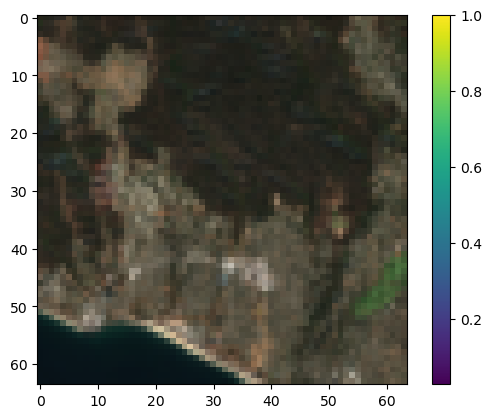

In [61]:
img = patch[0:3,:,:]
plt.imshow(img.permute(1, 2, 0), vmax=1)
plt.colorbar()
plt.show()

(tensor(0.5362), tensor(0.5362))

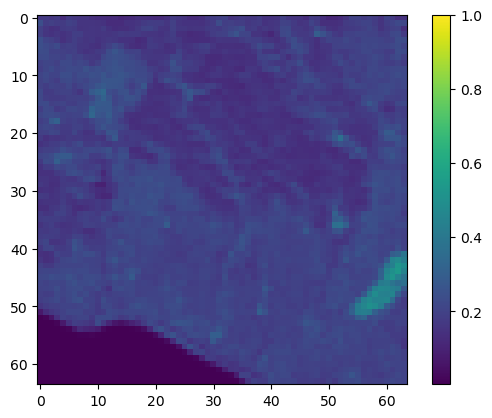

In [62]:
NIR_image = patch[3].unsqueeze(dim=0)#-> Remove first dim (channel) 
plt.imshow(NIR_image.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()
NIR_image.max(), patch[3].max()

(tensor(0.0032), tensor(0.5362))

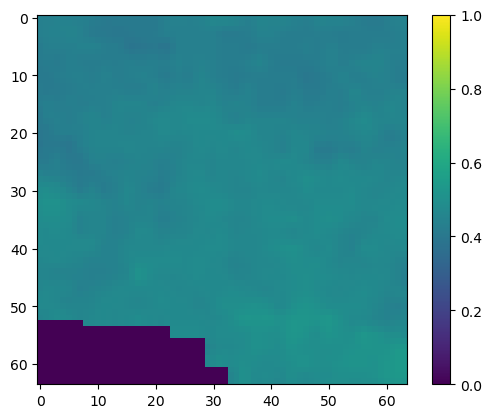

In [63]:
ped = patch[-1].unsqueeze(dim=0)#-> Remove first dim (channel) 
plt.imshow(ped.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()
patch[3].min(), patch[3].max()

In [2]:
N_LABELS = 5079
N_INPUTS = 31
GAMMA = 0.1
DROPOUT = 0.7
NUM_WORKERS = 8
BATCH_SIZE = 64

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [23]:
model_path = 'inet_20221211-14-59.pt'
model_path = 'inet_20221211-5-38.pt'
model_path = 'inet_20221211-21-9.pt'
dict_path = 'inet_20221212-124-b128-e0-SGD.tar'
dict_path = 'inet_20221212-1441-b128-e200-SGD.tar'


inet, optimizer, scheduler, train_loss = load_model(dict_path)

Epochs:200 | Batch_size: 128 | Gamma: 0.1 | LR: 0.1 | Model: inet | Optim: SGD
Loading InceptioNet
Optimizer: SGD
Scheduler: MultiStepLR


In [24]:
inet = inet.to(device)

In [73]:
inet

InceptionNet in mlmc mode

# Run Inference

In [99]:
validate(num_epochs=1, model=inet, loader=val_loader, device=device, validation_size=-1, top_k=[1,5,10,20,30,50,100])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

(5025, 5079) (5025, 5079)
Accuracy [k=1]:		0.0398%
Accuracy [k=1,s=1346]:	0.00347%
Accuracy [k=5]:		0.418%
Accuracy [k=5,s=1346]:	0.125%
Accuracy [k=10]:		0.955%
Accuracy [k=10,s=1346]:	0.472%
Accuracy [k=20]:		1.67%
Accuracy [k=20,s=1346]:	0.932%
Accuracy [k=30]:		2.43%
Accuracy [k=30,s=1346]:	1.4%
Accuracy [k=50]:		3.46%
Accuracy [k=50,s=1346]:	2.06%
Accuracy [k=100]:		7.66%
Accuracy [k=100,s=1346]:	4.64%


In [55]:
del val_loader, val_dataset
gc.collect()

29121

## Test BCELoss

In [ ]:
targets = ca_val_gdf.drop(['geometry'], axis=1).to_numpy()
targets

In [ ]:
import torch.nn.functional as F
batch_size = 8

loss_fn = torch.nn.BCELoss()

# outputs_before_sigmoid = torch.randn(batch_size, num_classes)
fake_output = torch.randn(num_classes, dtype=float)
sigmoid_outputs = torch.sigmoid(fake_output)
softmax_outputs = F.softmax(fake_output, dim=-1)


#or perfect guess
outputs = torch.from_numpy(targets[5])

target = torch.from_numpy(targets[5])
# target_classes = torch.randint(0, 2, (batch_size, num_classes),dtype=torch.float)  # randints in [0, 2).

# target_classes = torch.tensor([[1.0],[0.0]])
# sigmoid_outputs = torch.tensor([[0.8],[0.]])
print(len(sigmoid_outputs), len(target))
print(type(sigmoid_outputs), type(torch.from_numpy(targets[5])))
loss = loss_fn(sigmoid_outputs, target)
loss2 = loss_fn(softmax_outputs, target)
# loss = loss_fn(outputs, target)
print(loss, loss2)

In [ ]:
sigmoid_outputs.sum(), target.sum(), softmax_outputs.sum()

In [ ]:
fake_output

In [ ]:
import zarr
import numcodecs

In [ ]:
z = zarr.empty(1, dtype=object, object_codec=numcodecs.Pickle())
z[0] = [patch, 

In [ ]:
z[0]

# Original Training for InceptioNet

### Debug: setting paths for imports

In [ ]:
import sys
for path in sys.path:
    print(path)
    

In [ ]:
# sys.path.remove('/models')
# sys.path.remove('/raster')
# sys.path.remove('model/')
sys.path.remove('/home/jovyan/sdm-geolifeCLEF/../raster')
# sys.path.remove('/models')
# sys.path.remove('/raster')
